In [1]:
import numpy as np
import core.vem as vem
from typing import Tuple

# geometry data
L = 2.0
nodes = np.array([[0,0],[0,L],[L,L],[L,0]])
elements = np.array([[0,1],[1,2],[2,3]])
supp = np.array([[0,1,1,1], [3,1,1,1]])
I = 36e-4
A = 0.12

# material data
E = 20e6

# loads
load = np.array([[1,2]])
q = -400
t = 0
f_dist = vem.buildBeamDistributedLoad(load,t,q,nodes)

# stiffness matrix
K = vem.buildGlobaBeamK(nodes, elements, E, A, I, 1)

# apply DBC
K, f = vem.applyDBCBeam(K, f_dist, supp)

# solve
print()
print("######################### Beam ##########################")
uh_vem = np.linalg.solve(K,f)
print(uh_vem)
print("#########################################################")


######################### Beam ##########################
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.16360817e-04
 -3.20308731e-04 -8.04745594e-04  5.44061872e-05 -3.46357935e-04
  6.33978590e-04  0.00000000e+00  0.00000000e+00  0.00000000e+00]
#########################################################


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

def compute_loss(K, uh, F):
    """
    Compute the loss function as (K * uh - F)^2 using PyTorch

    Parameters:
    K (torch.Tensor): Stiffness matrix (ndof x ndof)
    uh (torch.Tensor): Solution vector (ndof x 1)
    F (torch.Tensor): Load vector (ndof x 1)

    Returns:
    torch.Tensor: The loss value
    """
    # Compute the residual
    R = torch.matmul(K, uh) - F
    
    # Compute the loss (squared residual)
    loss = torch.sum(R**2)
    
    return loss

def compute_boundary_loss(uh, supp):
    """
    Compute the loss function for enforcing the Dirichlet boundary conditions.

    Parameters:
    uh (torch.Tensor): Solution vector (ndof x 1)
    supp (torch.Tensor): Support vector (ndof x N, where N is the number of nodes with boundary conditions)

    Returns:
    torch.Tensor: The loss value as a PyTorch tensor
    """
    # Initialize the loss as a scalar tensor with zero
    loss = torch.tensor(0.0, dtype=torch.float32, requires_grad=True)
    
    for node in supp:
        if node[1] == 1:  # x-direction fixed
            k = 3 * int(node[0])
            loss = loss + uh[k] ** 2  # Avoid in-place operation by using a new tensor
        if node[2] == 1:  # y-direction fixed
            k = 3 * int(node[0]) + 1
            loss = loss + uh[k] ** 2  # Avoid in-place operation by using a new tensor
        if node[3] == 1:  # z-direction fixed
            k = 3 * int(node[0]) + 2
            loss = loss + uh[k] ** 2  # Avoid in-place operation by using a new tensor

    return loss

# Define neural network for the beam problem
class BeamApproximator(nn.Module):
    def __init__(self, input_dim, ndof):
        super(BeamApproximator, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, ndof)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Assuming nodes, K, and f are already defined
ndof = 3 * len(nodes)
input_dim = 2*len(nodes)

nodes = nodes.flatten()
nodes = torch.tensor(nodes, dtype=torch.float32, requires_grad=True)

# Initialize the model and optimizer
model = BeamApproximator(input_dim, ndof)
optimizer = optim.Adam(model.parameters(), lr=0.01)

K = torch.tensor(K, dtype=torch.float32, requires_grad=True)
f = torch.tensor(f, dtype=torch.float32, requires_grad=True)

/opt/anaconda3/envs/ml-env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
epochs = 4000
for  epoch in range(epochs):
    optimizer.zero_grad()
    uh = model(nodes)
    loss = compute_loss(K, uh, f)
    loss_bc = compute_boundary_loss(uh, supp)
    loss = loss + loss_bc
    loss.backward()
    optimizer.step()
    print(f'Epoch: {epoch+1}, Loss: {loss.item()}')

Epoch: 1, Loss: 157915725824.0
Epoch: 2, Loss: 1730864349184.0
Epoch: 3, Loss: 183860445184.0
Epoch: 4, Loss: 152341151744.0
Epoch: 5, Loss: 318287085568.0
Epoch: 6, Loss: 241288970240.0
Epoch: 7, Loss: 120441708544.0
Epoch: 8, Loss: 45312303104.0
Epoch: 9, Loss: 18830266368.0
Epoch: 10, Loss: 18179633152.0
Epoch: 11, Loss: 25735995392.0
Epoch: 12, Loss: 31042084864.0
Epoch: 13, Loss: 31681918976.0
Epoch: 14, Loss: 28502423552.0
Epoch: 15, Loss: 23204767744.0
Epoch: 16, Loss: 15962362880.0
Epoch: 17, Loss: 9374962688.0
Epoch: 18, Loss: 3341465344.0
Epoch: 19, Loss: 935258240.0
Epoch: 20, Loss: 2720799232.0
Epoch: 21, Loss: 4271030016.0
Epoch: 22, Loss: 3667213312.0
Epoch: 23, Loss: 1809597440.0
Epoch: 24, Loss: 581284480.0
Epoch: 25, Loss: 942827136.0
Epoch: 26, Loss: 1562007168.0
Epoch: 27, Loss: 1374206208.0
Epoch: 28, Loss: 784272192.0
Epoch: 29, Loss: 358675776.0
Epoch: 30, Loss: 332520896.0
Epoch: 31, Loss: 563052160.0
Epoch: 32, Loss: 769080000.0
Epoch: 33, Loss: 774916544.0
Epoc

In [4]:
# Set the model to evaluation mode
model.eval()

# Ensure gradients are not tracked during prediction
with torch.no_grad():
    # Use the trained model to make predictions
    predicted_displacements = model(nodes)

# Print or use the predicted displacements
print("Predicted displacements:", predicted_displacements)

Predicted displacements: tensor([ 9.7603e-07,  1.2331e-06, -1.8626e-08,  1.1367e-04, -3.1910e-04,
        -8.0428e-04,  5.2866e-05, -3.4729e-04,  6.3572e-04, -2.8312e-07,
        -8.6473e-07, -1.9325e-07])


In [5]:
def compute_l2_error(uh_vem, uh_nn):
    """
    Compute the L2 norm error between the FEM and NN displacement fields.

    Parameters:
    uh_fem (torch.Tensor): Displacement field from FEM (ndof x 1)
    uh_nn (torch.Tensor): Displacement field from NN (ndof x 1)

    Returns:
    torch.Tensor: L2 norm error as a scalar
    """
    error = torch.norm(uh_nn - uh_vem) / torch.norm(uh_vem)
    return error

In [6]:
compute_l2_error(torch.tensor(uh_vem), predicted_displacements)

tensor(0.0038, dtype=torch.float64)

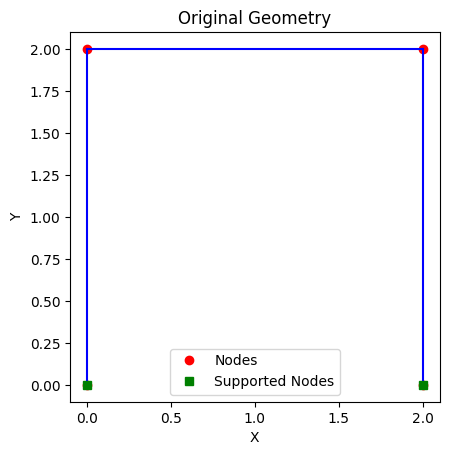

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Geometry data
L = 2.0
nodes = np.array([[0,0],[0,L],[L,L],[L,0]])
elements = np.array([[0,1],[1,2],[2,3]])
supp = np.array([[0,1,1,1], [3,1,1,1]])

# Function to plot the original geometry
def plot_geometry(nodes, elements, supp):
    fig, ax = plt.subplots()
    
    # Plot nodes
    ax.plot(nodes[:, 0], nodes[:, 1], 'ro', label='Nodes')
    
    # Plot elements as lines connecting nodes
    for element in elements:
        element_coords = nodes[element]
        ax.plot(element_coords[:, 0], element_coords[:, 1], 'b-')
    
    # Highlight supported nodes
    for node in supp[:, 0]:
        ax.plot(nodes[node, 0], nodes[node, 1], 'gs', label='Supported Nodes' if node == supp[0, 0] else "")
    
    ax.set_aspect('equal')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Original Geometry')
    plt.legend()
    plt.show()

# Plot the original geometry
plot_geometry(nodes, elements, supp)

In [8]:
num_elements_per_edge = 2

x_coords = np.linspace(0, L, num_elements_per_edge + 1)
y_coords = np.linspace(0, L, num_elements_per_edge + 1)

top_nodes = np.array([[x, L] for x in x_coords if x != 0])
left_nodes = np.array([[0, y] for y in y_coords])
right_nodes = np.array([[L, y] for y in reversed(y_coords) if y != L])

nodes = np.vstack([left_nodes, top_nodes, right_nodes])

elements = np.array([[i, i+1] for i in range(len(nodes)-1)])
flatten_elements = elements.flatten()

supp = np.array([[flatten_elements[0], 1, 1, 1], [flatten_elements[-1], 1, 1, 1]])

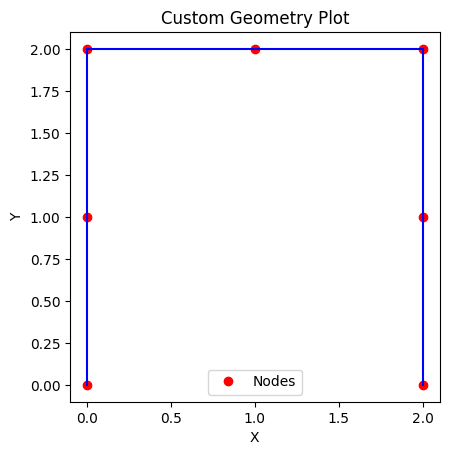

In [9]:
def plot_nodes(nodes):
    fig, ax = plt.subplots()
    
    # Plot nodes
    ax.plot(nodes[:, 0], nodes[:, 1], 'ro', label='Nodes')

    # Plot elements as lines connecting nodes
    for element in elements:
        element_coords = nodes[element]
        ax.plot(element_coords[:, 0], element_coords[:, 1], 'b-')

    ax.set_aspect('equal')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Custom Geometry Plot')
    plt.legend()
    plt.show()

# Plot the nodes
plot_nodes(nodes)

In [10]:
# geometry data
L = 2.0
I = 36e-4
A = 0.12

# material data
E = 20e6

# loads
load = np.array([[2,3],[3,4]])
q = -400
t = 0
f_dist = vem.buildBeamDistributedLoad(load,t,q,nodes)

# stiffness matrix
K = vem.buildGlobaBeamK(nodes, elements, E, A, I, 1)

# apply DBC
K, f = vem.applyDBCBeam(K, f_dist, supp)

# solve
print()
print("######################### Beam ##########################")
uh_vem = np.linalg.solve(K,f)
print(uh_vem)
print("#########################################################")


######################### Beam ##########################
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.44133539e-04
 -1.66666667e-04  1.37341906e-04  2.71665308e-05 -3.33333333e-04
 -6.30867216e-04 -9.29349757e-20 -8.80248423e-04 -9.60632642e-21
 -2.71665308e-05 -3.33333333e-04  6.30867216e-04  1.44133539e-04
 -1.66666667e-04 -1.37341906e-04  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
#########################################################


In [11]:
# Define neural network for the beam problem
class BeamApproximator(nn.Module):
    def __init__(self, input_dim, layers, ndof):
        super(BeamApproximator, self).__init__()
        # First layer from input to the first hidden layer
        self.fin = nn.Linear(input_dim, layers[0])
        
        # Hidden layers
        self.hidden = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        # Final output layer from the last hidden layer to the output (ndof)
        self.fout = nn.Linear(layers[-1], ndof)

    def forward(self, x):
        # Pass through the first layer
        z = torch.relu(self.fin(x))
        
        # Pass through the hidden layers
        for layer in self.hidden:
            z = torch.relu(layer(z))
        
        # Final output layer
        z = self.fout(z)
        
        return z

# Assuming nodes, K, and f are already defined
ndof = 3 * len(nodes)
input_dim = 2*len(nodes)

nodes = nodes.flatten()
nodes = torch.tensor(nodes, dtype=torch.float32, requires_grad=True)

# Initialize the model and optimizer
layers = [128, 128, 256, 256, 512, 512, 512]
model = BeamApproximator(input_dim, layers, ndof)
optimizer = optim.Adam(model.parameters(), lr=0.01)

K = torch.tensor(K, dtype=torch.float32, requires_grad=True)
f = torch.tensor(f, dtype=torch.float32, requires_grad=True)

In [12]:
epochs = 40000
for  epoch in range(epochs):
    optimizer.zero_grad()
    uh = model(nodes)
    loss = compute_loss(K, uh, f)
    loss_bc = compute_boundary_loss(uh, supp)
    loss = loss + loss_bc
    loss.backward()
    optimizer.step()
    print(f'Epoch: {epoch+1}, Loss: {loss.item()}')

Epoch: 1, Loss: 342766518272.0
Epoch: 2, Loss: 1008270080737280.0
Epoch: 3, Loss: 35553488896.0
Epoch: 4, Loss: 1067179442176.0
Epoch: 5, Loss: 435444056064.0
Epoch: 6, Loss: 66882379776.0
Epoch: 7, Loss: 2438260588544.0
Epoch: 8, Loss: 1568767606784.0
Epoch: 9, Loss: 1351077199872.0
Epoch: 10, Loss: 654064812032.0
Epoch: 11, Loss: 393349431296.0
Epoch: 12, Loss: 203729076224.0
Epoch: 13, Loss: 525781958656.0
Epoch: 14, Loss: 100254466048.0
Epoch: 15, Loss: 139773657088.0
Epoch: 16, Loss: 79940247552.0
Epoch: 17, Loss: 327768113152.0
Epoch: 18, Loss: 10760389394432.0
Epoch: 19, Loss: 105683443712.0
Epoch: 20, Loss: 248264130560.0
Epoch: 21, Loss: 332700680192.0
Epoch: 22, Loss: 138483286016.0
Epoch: 23, Loss: 64980967424.0
Epoch: 24, Loss: 139274321920.0
Epoch: 25, Loss: 10860952576.0
Epoch: 26, Loss: 139150688256.0
Epoch: 27, Loss: 6696054784.0
Epoch: 28, Loss: 146977030144.0
Epoch: 29, Loss: 21944600576.0
Epoch: 30, Loss: 59710926848.0
Epoch: 31, Loss: 36423471104.0
Epoch: 32, Loss: 

In [13]:
def compute_l2_error(uh_vem, uh_nn):
    """
    Compute the L2 norm error between the FEM and NN displacement fields.

    Parameters:
    uh_fem (torch.Tensor): Displacement field from FEM (ndof x 1)
    uh_nn (torch.Tensor): Displacement field from NN (ndof x 1)

    Returns:
    torch.Tensor: L2 norm error as a scalar
    """
    error = torch.norm(uh_nn - uh_vem) / torch.norm(uh_vem)
    return error

def compute_energy_error(K, uh_fem, uh_nn):
    """
    Compute the energy error between the FEM and NN solutions.

    Parameters:
    K (torch.Tensor): Stiffness matrix (ndof x ndof)
    uh_fem (torch.Tensor): Displacement field from FEM (ndof x 1)
    uh_nn (torch.Tensor): Displacement field from NN (ndof x 1)

    Returns:
    torch.Tensor: Energy error as a scalar
    """
    # Ensure all tensors are of the same type (float32)
    K = K.float()
    uh_fem = uh_fem.float()
    uh_nn = uh_nn.float()
    
    # Compute strain energy for FEM and NN solutions
    U_fem = 0.5 * torch.matmul(uh_fem.T, torch.matmul(K, uh_fem))
    U_nn = 0.5 * torch.matmul(uh_nn.T, torch.matmul(K, uh_nn))

    # Compute energy error
    energy_error = (U_nn - U_fem) / U_fem
    return energy_error.abs()  # Return the absolute value of the error

import torch

def compute_h1_norm(K, uh_fem, uh_nn):
    """
    Compute the H1 norm between the FEM and NN solutions.
    
    Parameters:
    K (torch.Tensor): Stiffness matrix (ndof x ndof)
    uh_fem (torch.Tensor): Displacement field from FEM (ndof x 1)
    uh_nn (torch.Tensor): Displacement field from NN (ndof x 1)

    Returns:
    torch.Tensor: H1 norm error as a scalar
    """
    # Ensure all tensors are of the same type and have requires_grad=True
    uh_fem = uh_fem.float().requires_grad_(True)
    uh_nn = uh_nn.float().requires_grad_(True)

    # Compute L2 norm of the displacement field
    l2_error = torch.norm(uh_nn - uh_fem) ** 2

    # Compute gradient (strain) of the displacement fields
    grad_uh_fem = torch.autograd.grad(uh_fem.sum(), uh_fem, create_graph=True)[0]
    grad_uh_nn = torch.autograd.grad(uh_nn.sum(), uh_nn, create_graph=True)[0]

    # Compute L2 norm of the gradient (strain)
    grad_error = torch.norm(grad_uh_nn - grad_uh_fem) ** 2

    # Combine L2 norm of the displacement and gradient
    h1_error = torch.sqrt(l2_error + grad_error)

    return h1_error

In [14]:
# Set the model to evaluation mode
model.eval()

# Ensure gradients are not tracked during prediction
with torch.no_grad():
    # Use the trained model to make predictions
    predicted_displacements = model(nodes)

# Print or use the predicted displacements
print("Predicted displacements:", predicted_displacements)

l2_error = compute_l2_error(torch.tensor(uh_vem), predicted_displacements).item()
energy_error = compute_energy_error(K, torch.tensor(uh_vem), predicted_displacements).item()
h1_error = compute_h1_norm(K, torch.tensor(uh_vem), predicted_displacements).item()

print(f"L2 error: {l2_error}")
print(f"Energy error: {energy_error}")
print(f"H1 error: {h1_error}")

Predicted displacements: tensor([-2.5408e-07, -3.8494e-08,  2.1611e-10, -1.2973e-04, -1.5587e-04,
         1.2296e-04,  1.2894e-05, -3.4370e-04, -6.4405e-04,  1.4199e-05,
        -8.8001e-04, -2.0937e-05, -4.1388e-05, -3.2337e-04,  6.1804e-04,
         1.5841e-04, -1.7707e-04, -1.5161e-04,  9.1548e-12,  4.3193e-11,
        -5.2591e-07])
L2 error: 0.03697695174107445
Energy error: 0.020806971937417984
H1 error: 5.1361406804062426e-05


/var/folders/r8/9jdwwqz11dq7_2m0n6cds_k40000gn/T/ipykernel_99751/787023990.py:33: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3641.)
  U_fem = 0.5 * torch.matmul(uh_fem.T, torch.matmul(K, uh_fem))


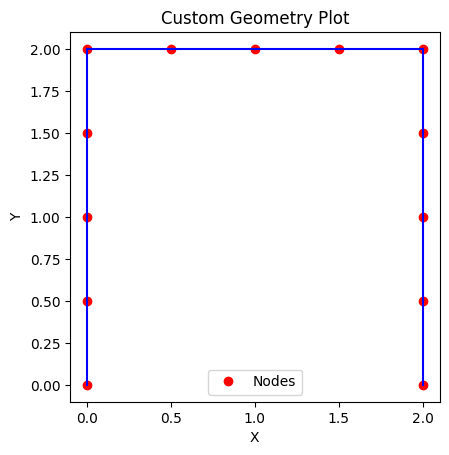


######################### Beam ##########################
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.02895092e-06
 -8.92347406e-05  3.50292908e-06 -2.21989101e-06 -1.78469481e-04
 -7.35204331e-06  9.06325122e-06 -2.46870888e-04 -4.23934002e-05
 -8.95727676e-05 -2.73605629e-04  4.32324601e-04 -9.12334024e-05
 -1.03010644e-04  2.66448138e-04 -9.28940373e-05 -1.84706139e-05
  8.81047799e-05 -9.45546721e-05 -2.97386807e-06 -9.72499864e-06
 -9.62153070e-05  2.36056291e-05  1.32435785e-04 -4.02876350e-05
  1.77042218e-05  9.58877773e-05 -8.57068980e-06  1.18028146e-05
  3.55928779e-05  1.63764844e-07  5.90140728e-06  3.95781521e-06
  0.00000000e+00  0.00000000e+00  0.00000000e+00]
#########################################################
Epoch: 1, Loss: 2845257236480.0
Epoch: 2, Loss: 1691691515904.0
Epoch: 3, Loss: 885732802560.0
Epoch: 4, Loss: 205408927744.0
Epoch: 5, Loss: 332926550016.0
Epoch: 6, Loss: 348711518208.0
Epoch: 7, Loss: 181234712576.0
Epoch: 8, Loss: 83462225920.0

In [15]:
num_elements_per_edge = 4

# geometry data
L = 2.0
I = 36e-4
A = 0.12

# material data
E = 20e6

x_coords = np.linspace(0, L, num_elements_per_edge + 1)
y_coords = np.linspace(0, L, num_elements_per_edge + 1)

top_nodes = np.array([[x, L] for x in x_coords if x != 0])
left_nodes = np.array([[0, y] for y in y_coords])
right_nodes = np.array([[L, y] for y in reversed(y_coords) if y != L])

nodes = np.vstack([left_nodes, top_nodes, right_nodes])

elements = np.array([[i, i+1] for i in range(len(nodes)-1)])
flatten_elements = elements.flatten()

supp = np.array([[flatten_elements[0], 1, 1, 1], [flatten_elements[-1], 1, 1, 1]])

def plot_nodes(nodes):
    fig, ax = plt.subplots()
    
    # Plot nodes
    ax.plot(nodes[:, 0], nodes[:, 1], 'ro', label='Nodes')

    # Plot elements as lines connecting nodes
    for element in elements:
        element_coords = nodes[element]
        ax.plot(element_coords[:, 0], element_coords[:, 1], 'b-')

    ax.set_aspect('equal')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Custom Geometry Plot')
    plt.legend()
    plt.show()

# Plot the nodes
plot_nodes(nodes)

# loads
load = np.array([[2,3],[3,4]])
q = -400
t = 0
f_dist = vem.buildBeamDistributedLoad(load,t,q,nodes)

# stiffness matrix
K = vem.buildGlobaBeamK(nodes, elements, E, A, I, 1)

# apply DBC
K, f = vem.applyDBCBeam(K, f_dist, supp)

# solve
print()
print("######################### Beam ##########################")
uh_vem = np.linalg.solve(K,f)
print(uh_vem)
print("#########################################################")

def compute_loss(K, uh, F):
    """
    Compute the loss function as (K * uh - F)^2 using PyTorch

    Parameters:
    K (torch.Tensor): Stiffness matrix (ndof x ndof)
    uh (torch.Tensor): Solution vector (ndof x 1)
    F (torch.Tensor): Load vector (ndof x 1)

    Returns:
    torch.Tensor: The loss value
    """
    # Compute the residual
    R = torch.matmul(K, uh) - F
    
    # Compute the loss (squared residual)
    loss = torch.sum(R**2)
    
    return loss

def compute_boundary_loss(uh, supp):
    """
    Compute the loss function for enforcing the Dirichlet boundary conditions.

    Parameters:
    uh (torch.Tensor): Solution vector (ndof x 1)
    supp (torch.Tensor): Support vector (ndof x N, where N is the number of nodes with boundary conditions)

    Returns:
    torch.Tensor: The loss value as a PyTorch tensor
    """
    # Initialize the loss as a scalar tensor with zero
    loss = torch.tensor(0.0, dtype=torch.float32, requires_grad=True)
    
    for node in supp:
        if node[1] == 1:  # x-direction fixed
            k = 3 * int(node[0])
            loss = loss + uh[k] ** 2  # Avoid in-place operation by using a new tensor
        if node[2] == 1:  # y-direction fixed
            k = 3 * int(node[0]) + 1
            loss = loss + uh[k] ** 2  # Avoid in-place operation by using a new tensor
        if node[3] == 1:  # z-direction fixed
            k = 3 * int(node[0]) + 2
            loss = loss + uh[k] ** 2  # Avoid in-place operation by using a new tensor

    return loss

# Define neural network for the beam problem
class BeamApproximator(nn.Module):
    def __init__(self, input_dim, layers, ndof):
        super(BeamApproximator, self).__init__()
        # First layer from input to the first hidden layer
        self.fin = nn.Linear(input_dim, layers[0])
        
        # Hidden layers
        self.hidden = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        # Final output layer from the last hidden layer to the output (ndof)
        self.fout = nn.Linear(layers[-1], ndof)

    def forward(self, x):
        # Pass through the first layer
        z = torch.relu(self.fin(x))
        
        # Pass through the hidden layers
        for layer in self.hidden:
            z = torch.relu(layer(z))
        
        # Final output layer
        z = self.fout(z)
        
        return z

# Assuming nodes, K, and f are already defined
ndof = 3 * len(nodes)
input_dim = 2*len(nodes)

nodes = nodes.flatten()
nodes = torch.tensor(nodes, dtype=torch.float32, requires_grad=True)

# Initialize the model and optimizer
layers = [128, 128, 256, 256, 512, 512, 512, 1024]
# layers = [128, 128, 256, 256, 512]
model = BeamApproximator(input_dim, layers, ndof)
optimizer = optim.Adam(model.parameters(), lr=0.001)

K = torch.tensor(K, dtype=torch.float32, requires_grad=True)
f = torch.tensor(f, dtype=torch.float32, requires_grad=True)

epochs = 70000
for  epoch in range(epochs):
    optimizer.zero_grad()
    uh = model(nodes)
    loss = compute_loss(K, uh, f)
    loss_bc = compute_boundary_loss(uh, supp)
    loss = loss + loss_bc
    loss.backward()
    optimizer.step()
    print(f'Epoch: {epoch+1}, Loss: {loss.item()}')

In [16]:
# Set the model to evaluation mode
model.eval()

# Ensure gradients are not tracked during prediction
with torch.no_grad():
    # Use the trained model to make predictions
    predicted_displacements = model(nodes)

# Print or use the predicted displacements
print("Predicted displacements:", predicted_displacements)

l2_error = compute_l2_error(torch.tensor(uh_vem), predicted_displacements).item()
energy_error = compute_energy_error(K, torch.tensor(uh_vem), predicted_displacements).item()
h1_error = compute_h1_norm(K, torch.tensor(uh_vem), predicted_displacements).item()

print(f"L2 error: {l2_error}")
print(f"Energy error: {energy_error}")
print(f"H1 error: {h1_error}")

Predicted displacements: tensor([-4.7238e-11, -7.4063e-08, -4.6091e-13,  1.3991e-05, -3.8092e-05,
        -1.6372e-05, -2.5930e-05, -2.2926e-04,  5.8303e-05,  4.4211e-05,
        -1.9681e-04, -8.2900e-05, -1.3226e-04, -3.2135e-04,  3.8526e-04,
        -4.7572e-05, -6.1615e-05,  2.2907e-04, -1.3335e-04, -4.4994e-05,
         1.4002e-04, -5.8871e-05,  5.5375e-06, -6.8661e-05, -1.2684e-04,
         2.4873e-05,  1.1668e-04, -1.1079e-05,  1.3250e-05,  1.0183e-04,
        -3.7038e-05,  1.6803e-05,  5.9781e-05,  2.8065e-05,  4.4510e-07,
        -2.4149e-05,  2.1425e-11,  6.1739e-05,  8.3127e-12])
L2 error: 0.2957943531329643
Energy error: 6.142338752746582
H1 error: 0.00021498028945643455


In [17]:
def generate_geometry(num_elements_per_edge: int)->Tuple[np.ndarray, np.ndarray, np.ndarray]:
    x_coords = np.linspace(0, L, num_elements_per_edge + 1)
    y_coords = np.linspace(0, L, num_elements_per_edge + 1)

    top_nodes = np.array([[x, L] for x in x_coords if x != 0])
    left_nodes = np.array([[0, y] for y in y_coords])
    right_nodes = np.array([[L, y] for y in reversed(y_coords) if y != L])

    nodes = np.vstack([left_nodes, top_nodes, right_nodes])

    elements = np.array([[i, i+1] for i in range(len(nodes)-1)])
    flatten_elements = elements.flatten()

    supp = np.array([[flatten_elements[0], 1, 1, 1], [flatten_elements[-1], 1, 1, 1]])

    return nodes, elements, supp

def solve_vem(nodes: np.ndarray, elements: np.ndarray, supp: np.ndarray)->np.ndarray:
    I = 36e-4
    A = 0.12

    # material data
    E = 20e6

    # loads
    load = np.array([[2,3],[3,4]])
    q = -400
    t = 0
    f_dist = vem.buildBeamDistributedLoad(load,t,q,nodes)

    # stiffness matrix
    K = vem.buildGlobaBeamK(nodes, elements, E, A, I, 1)

    # apply DBC
    K, f = vem.applyDBCBeam(K, f_dist, supp)

    # solve
    uh_vem = np.linalg.solve(K,f)

    return uh_vem, K, f

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import core.vem as vem
from typing import Tuple

import utils.mesh as mesh
import core.loss as loss_function
import core.errors as errors
import core.neural_backend as neural

import solve_vem

def train_material(epochs, nodes, K, f, E, A, I, verbose=True, noramlize_inputs=False, network_type='material'):
    ndof = 3 * len(nodes)
    input_dim = 2*len(nodes) + 3

    input_dim_nodes = 2*len(nodes)
    input_dim_materials = 3

    # Original material parameters
    material_params_1 = torch.tensor([E, A, I], dtype=torch.float32)
    print(f"Material params shape: {material_params_1.shape}")

    # Perturbed material parameters (slightly changed)
    material_params_2 = torch.tensor([E *1.1, A * 1.1, I * 0.9], dtype=torch.float32)

    if noramlize_inputs:
        nodes, material_params_1 = neural.normalize_inputs(nodes, material_params_1)
        _, material_params_2 = neural.normalize_inputs(nodes, material_params_2)

    nodes = nodes.flatten()
    nodes = torch.tensor(nodes, dtype=torch.float32, requires_grad=True)
    print(f"Nodes shape: {nodes.shape}")

    input_vector = torch.cat([nodes, material_params_1])

    lr = 1e-3

    # Initialize the model and optimizer
    if network_type == 'residual':
        # layers = [128, 128, 256, 256, 512, 512, 512, 1024, 1024, 1024, 1024, 1024, 1024]
        layers = [128, 128, 256, 256, 512, 512, 512, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 2048, 2048]
        # layers = [128, 128, 256, 256, 512, 512, 512, 512]
        # layers = [128, 256, 512]
        concatanate=True
        model = neural.ResidualBeamApproximator(input_dim, layers, ndof)
    if network_type == 'material':
        nodes_layers = [128, 256, 512, 512, 512, 512]  # Layers for nodes sub-network
        material_layers = [128, 128, 256, 256, 512, 512, 512, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 2048, 2048] # Layers for materials sub-network
        final_layers = [1024, 1024, 1024, 1024]  # Layers for final combination network
        # Concatanete the nodes and materials
        concatanate = False
        model = neural.BeamApproximatorWithMaterials(
            input_dim_nodes=input_dim_nodes, 
            input_dim_materials=input_dim_materials, 
            nodes_layers=nodes_layers, 
            material_layers=material_layers, 
            final_layers=final_layers, 
            ndof=ndof)
    else:
        layers = [128, 128, 256, 256, 512, 512, 512, 1024, 1024, 1024, 1024, 1024, 1024]
        # layers = [128, 128, 256, 256, 512, 512, 512, 512]
        # layers = [128, 256, 512]
        concatanate=True
        model = neural.BeamApproximator(input_dim, layers, ndof)
    # optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    # optimizer = optim.Adam(model.parameters(), lr=0.0000000001, weight_decay=1e-4)
    # optimizer = optim.RMSprop(model.parameters(), lr=0.0000000001)

    K = torch.tensor(K, dtype=torch.float32, requires_grad=True)
    f = torch.tensor(f, dtype=torch.float32, requires_grad=True)

    total_loss_values = []
    loss_values = []
    material_loss_values = []
    sobolev_loss_values = []
    alpha_values_values = []

    # Scaling factor for loss
    # alpha = 1e-17

    for epoch in range(epochs):
        optimizer.zero_grad()
        # uh = model(input_vector)
        uh = model(nodes, material_params_1)
        
        # Compute the loss
        loss = loss_function.compute_loss_with_uh(uh_vem, uh)
        # Compute the sobolev loss
        sobolev_loss = loss_function.compute_sobolev_loss(model, nodes, material_params_1,loss, concatanate)
        # Compute material penalty
        material_penalty = loss_function.compute_material_penalty(model, nodes, material_params_1, material_params_2, concatanate)
        # Normalize the loss and penalty
        alpha = loss_function.normalize_loss_and_penalty(loss, material_penalty)
        total_loss = loss + alpha * material_penalty + sobolev_loss
        
        total_loss.backward()
        
        optimizer.step()
        if epoch > 0:
            total_loss_values.append(total_loss.item())
            loss_values.append(loss.item())
            material_loss_values.append(material_penalty.item())
            sobolev_loss_values.append(sobolev_loss.item())
            alpha_values_values.append(alpha)
        
        if verbose:
            print(f'Epoch: {epoch + 1}, Total Loss: {total_loss.item()}')
    
    if verbose:
        print("Training complete.")
        plt.plot(total_loss_values)
        plt.xlabel('Epochs (Sub-Epochs)')
        plt.ylabel('Loss')
        plt.title('Training Loss over Epochs')
        plt.show()

    return input_vector, model, total_loss_values, loss_values, material_loss_values, sobolev_loss_values, alpha_values_values